```
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
```



In [1]:
# Import additional libraries
import librosa
import soundfile
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Any
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline
import seaborn as sns
from joblib import dump, load
from tqdm import tqdm
import scipy.stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [3]:
def extract_advanced_features(file_name: str) -> np.ndarray:
    """
    Extract advanced audio features with enhanced feature set.

    Args:
        file_name (str): Path to the audio file

    Returns:
        np.ndarray: Array of extracted features or None if extraction fails
    """
    try:
        with soundfile.SoundFile(file_name) as sound_file:
            X = sound_file.read(dtype="float32")
            sample_rate = sound_file.samplerate

            # Ensure minimum duration
            target_length = 3 * sample_rate
            if len(X) < target_length:
                X = np.pad(X, (0, target_length - len(X)), mode='reflect')
            elif len(X) > target_length:
                X = X[:target_length]

            features = []

            # 1. Enhanced time-domain features
            features.extend([
                np.mean(np.abs(X)),                  # Mean absolute value
                np.std(X),                           # Standard deviation
                np.max(np.abs(X)),                   # Peak amplitude
                np.sum(np.square(X)),                # Energy
                np.mean(np.square(X)),               # RMS
                scipy.stats.skew(X),                 # Skewness
                scipy.stats.kurtosis(X),             # Kurtosis
                np.sum(np.diff(X) > 0),              # Zero crossing rate
                np.percentile(np.abs(X), 90)         # 90th percentile
            ])

            # 2. Enhanced spectral features
            stft = librosa.stft(X)
            stft_mag = np.abs(stft)
            stft_db = librosa.amplitude_to_db(stft_mag)

            features.extend([
                np.mean(stft_db),
                np.std(stft_db),
                scipy.stats.skew(stft_db.ravel()),
                scipy.stats.kurtosis(stft_db.ravel()),
                np.percentile(stft_db, 10),
                np.percentile(stft_db, 90)
            ])

            # 3. Enhanced MFCC features
            mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40)
            mfcc_delta = librosa.feature.delta(mfccs)
            mfcc_delta2 = librosa.feature.delta(mfccs, order=2)

            for feat in [mfccs, mfcc_delta, mfcc_delta2]:
                features.extend([
                    np.mean(feat, axis=1),
                    np.std(feat, axis=1),
                    scipy.stats.skew(feat, axis=1),
                    scipy.stats.kurtosis(feat, axis=1)
                ])

            # 4. Enhanced rhythm features
            onset_env = librosa.onset.onset_strength(y=X, sr=sample_rate)
            tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sample_rate)
            features.extend([
                tempo,
                len(beats) / (len(X) / sample_rate),  # Beat density
                np.std(np.diff(beats)) if len(beats) > 1 else 0  # Beat regularity
            ])

            # 5. Harmonic and percussive components
            y_harmonic, y_percussive = librosa.effects.hpss(X)
            features.extend([
                np.mean(y_harmonic),
                np.std(y_harmonic),
                np.mean(y_percussive),
                np.std(y_percussive)
            ])

            # 6. Enhanced mel spectrogram features
            mel_spec = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128)
            mel_spec_db = librosa.power_to_db(mel_spec)

            features.extend([
                np.mean(mel_spec_db, axis=1),
                np.std(mel_spec_db, axis=1),
                np.max(mel_spec_db, axis=1),
                np.min(mel_spec_db, axis=1)
            ])

            # 7. Spectral features
            spectral_centroids = librosa.feature.spectral_centroid(y=X, sr=sample_rate)[0]
            spectral_rolloff = librosa.feature.spectral_rolloff(y=X, sr=sample_rate)[0]
            spectral_bandwidth = librosa.feature.spectral_bandwidth(y=X, sr=sample_rate)[0]

            features.extend([
                np.mean(spectral_centroids),
                np.std(spectral_centroids),
                np.mean(spectral_rolloff),
                np.std(spectral_rolloff),
                np.mean(spectral_bandwidth),
                np.std(spectral_bandwidth)
            ])

            # Flatten and concatenate all features
            features = np.concatenate([np.array(f).flatten() for f in features])

            # Handle NaN and Inf values
            features = np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)

            return features

    except Exception as e:
        print(f"Error extracting features from {file_name}: {str(e)}")
        return None

In [4]:
def augment_minority_samples(X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Perform advanced data augmentation for minority classes.

    Args:
        X: Feature matrix
        y: Labels

    Returns:
        Tuple of augmented features and labels
    """
    unique_labels, counts = np.unique(y, return_counts=True)
    max_count = np.max(counts)
    X_aug, y_aug = X.copy(), y.copy()

    for label in unique_labels:
        count = counts[label == unique_labels][0]
        if count < max_count:
            idx = y == label
            X_minority = X[idx]

            # Calculate number of augmentations needed
            n_aug = max_count - count

            for i in range(n_aug):
                # Random sample
                sample = X_minority[i % len(X_minority)]

                # Apply random transformations
                aug_sample = sample.copy()

                # Add noise
                aug_sample += np.random.normal(0, 0.02, aug_sample.shape)

                # Random scaling
                aug_sample *= np.random.uniform(0.95, 1.05)

                # Random feature masking
                mask = np.random.rand(len(aug_sample)) > 0.1
                aug_sample = aug_sample * mask

                X_aug = np.vstack((X_aug, aug_sample))
                y_aug = np.append(y_aug, label)

    return X_aug, y_aug

In [14]:
def create_mlp():
    """
    Create an optimized MLPClassifier with carefully tuned architecture and parameters.
    """
    return MLPClassifier(
        hidden_layer_sizes=(2048, 1024, 512, 256),
        activation='relu',
        solver='adam',
        alpha=0.0005,
        batch_size=16,
        learning_rate='adaptive',
        learning_rate_init=0.0005,
        max_iter=20,
        early_stopping=True,
        validation_fraction=0.2,
        n_iter_no_change=3,
        momentum=0.95,
        nesterovs_momentum=True,
        beta_1=0.9,
        beta_2=0.999,
        verbose=True,
        random_state=42
    )

In [13]:
def create_pipeline():
    """
    Create an enhanced pipeline with better preprocessing.
    """
    return imbPipeline([
        ('scaler', RobustScaler()),
        # Adjusted PCA to retain more variance
        ('pca', PCA(n_components=0.99)),
        # More aggressive SMOTE settings
        ('smote', SMOTE(
            sampling_strategy='auto',
            k_neighbors=5,
            random_state=42
        )),
        ('classifier', create_mlp())
    ])

In [7]:
def load_and_preprocess_data(data_path: str, test_size: float = 0.2):
    """
    Enhanced data loading and preprocessing.
    """
    X, y = [], []

    files = glob.glob(os.path.join(data_path, "Actor_*", "*.wav"))

    # Calculate normalization statistics
    print("Calculating feature statistics...")
    temp_features = []
    for file in tqdm(files[:100]):
        feature = extract_advanced_features(file)
        if feature is not None:
            temp_features.append(feature)

    if temp_features:
        feature_mean = np.mean(temp_features, axis=0)
        feature_std = np.std(temp_features, axis=0) + 1e-10
    else:
        raise ValueError("No features could be extracted from the first pass")

    # Extract and normalize features
    print("\nExtracting and normalizing features...")
    for file in tqdm(files):
        file_name = os.path.basename(file)
        emotion = file_name.split("-")[2]

        feature = extract_advanced_features(file)
        if feature is not None:
            # Normalize features
            feature = (feature - feature_mean) / feature_std

            X.append(feature)
            y.append(emotion)

            # Add slight variations for all classes to improve robustness
            for _ in range(2):  # Create 2 variations for each sample
                aug_feature = feature.copy()

                # Add small random noise
                aug_feature += np.random.normal(0, 0.01, feature.shape)

                # Random scaling
                aug_feature *= np.random.uniform(0.98, 1.02)

                # Random feature masking
                mask = np.random.rand(len(feature)) > 0.05
                aug_feature = aug_feature * mask

                X.append(aug_feature)
                y.append(emotion)

    X = np.array(X)
    y = np.array(y)

    # Print dataset statistics
    print("\nInitial dataset statistics:")
    unique_labels, counts = np.unique(y, return_counts=True)
    for label, count in zip(unique_labels, counts):
        print(f"{label}: {count}")

    # Apply augmentation for minority classes
    print("\nApplying minority class augmentation...")
    X_augmented, y_augmented = augment_minority_samples(X, y)

    print("\nFinal dataset statistics:")
    unique_labels, counts = np.unique(y_augmented, return_counts=True)
    for label, count in zip(unique_labels, counts):
        print(f"{label}: {count}")

    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y_augmented)

    # Split with stratification
    return train_test_split(
        X_augmented,
        y_encoded,
        test_size=test_size,
        random_state=42,
        stratify=y_encoded
    )

In [8]:
def plot_training_history(model):
    """
    Plot training loss curve.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(model.loss_curve_, label='Training Loss')
    plt.title('Training Loss Over Time')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [9]:
def plot_confusion_matrix_heatmap(y_true, y_pred, label_encoder):
    """
    Plot confusion matrix as a heatmap with emotion labels.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=label_encoder.classes_,
        yticklabels=label_encoder.classes_
    )
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [10]:
# Load and prepare data
print("Loading and preprocessing data...")
data_path = "/content/drive/MyDrive/ML/Emotion Recognition/"
X_train, X_test, y_train, y_test = load_and_preprocess_data(data_path)

Loading and preprocessing data...
Calculating feature statistics...


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]



Extracting and normalizing features...


100%|██████████| 1440/1440 [07:15<00:00,  3.31it/s]



Initial dataset statistics:
01: 288
02: 576
03: 576
04: 576
05: 576
06: 576
07: 576
08: 576

Applying minority class augmentation...

Final dataset statistics:
01: 576
02: 576
03: 576
04: 576
05: 576
06: 576
07: 576
08: 576


In [15]:
# Create and train pipeline
print("\nTraining model...")
pipeline = create_pipeline()
pipeline.fit(X_train, y_train)


Training model...
Iteration 1, loss = 1.73444410
Validation score: 0.661247
Iteration 2, loss = 0.81323738
Validation score: 0.823848
Iteration 3, loss = 0.36851945
Validation score: 0.863144
Iteration 4, loss = 0.23353408
Validation score: 0.918699
Iteration 5, loss = 0.16325090
Validation score: 0.897019
Iteration 6, loss = 0.14588033
Validation score: 0.926829
Iteration 7, loss = 0.10161385
Validation score: 0.932249
Iteration 8, loss = 0.13480094
Validation score: 0.918699
Iteration 9, loss = 0.18486199
Validation score: 0.895664
Iteration 10, loss = 0.12667143
Validation score: 0.921409
Iteration 11, loss = 0.12053804
Validation score: 0.929539
Validation score did not improve more than tol=0.000100 for 3 consecutive epochs. Stopping.


Pipeline(steps=[('scaler', RobustScaler()), ('pca', PCA(n_components=0.99)),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 MLPClassifier(alpha=0.0005, batch_size=16, early_stopping=True,
                               hidden_layer_sizes=(2048, 1024, 512, 256),
                               learning_rate='adaptive',
                               learning_rate_init=0.0005, max_iter=20,
                               momentum=0.95, n_iter_no_change=3,
                               random_state=42, validation_fraction=0.2,
                               verbose=True))])


Plotting training history...


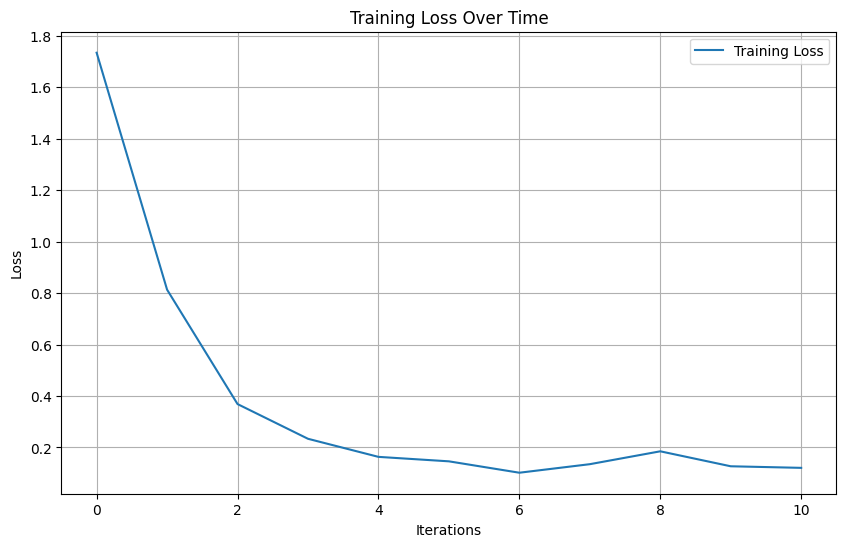

In [16]:
# Plot training history
print("\nPlotting training history...")
plot_training_history(pipeline.named_steps['classifier'])

In [17]:
# Evaluate model
print("\nEvaluating model...")
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {accuracy:.2%}")


Evaluating model...

Test Accuracy: 94.69%


In [18]:
# Print detailed classification report
print("\nClassification Report:")
label_encoder = LabelEncoder()
label_encoder.fit(['01', '02', '03', '04', '05', '06', '07', '08'])
print(classification_report(y_test, y_pred, zero_division=1))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       115
           1       0.99      0.99      0.99       115
           2       0.96      0.95      0.95       115
           3       0.87      0.95      0.91       116
           4       0.90      0.94      0.92       115
           5       0.94      0.89      0.91       115
           6       0.94      0.95      0.94       116
           7       0.99      0.94      0.96       115

    accuracy                           0.95       922
   macro avg       0.95      0.95      0.95       922
weighted avg       0.95      0.95      0.95       922



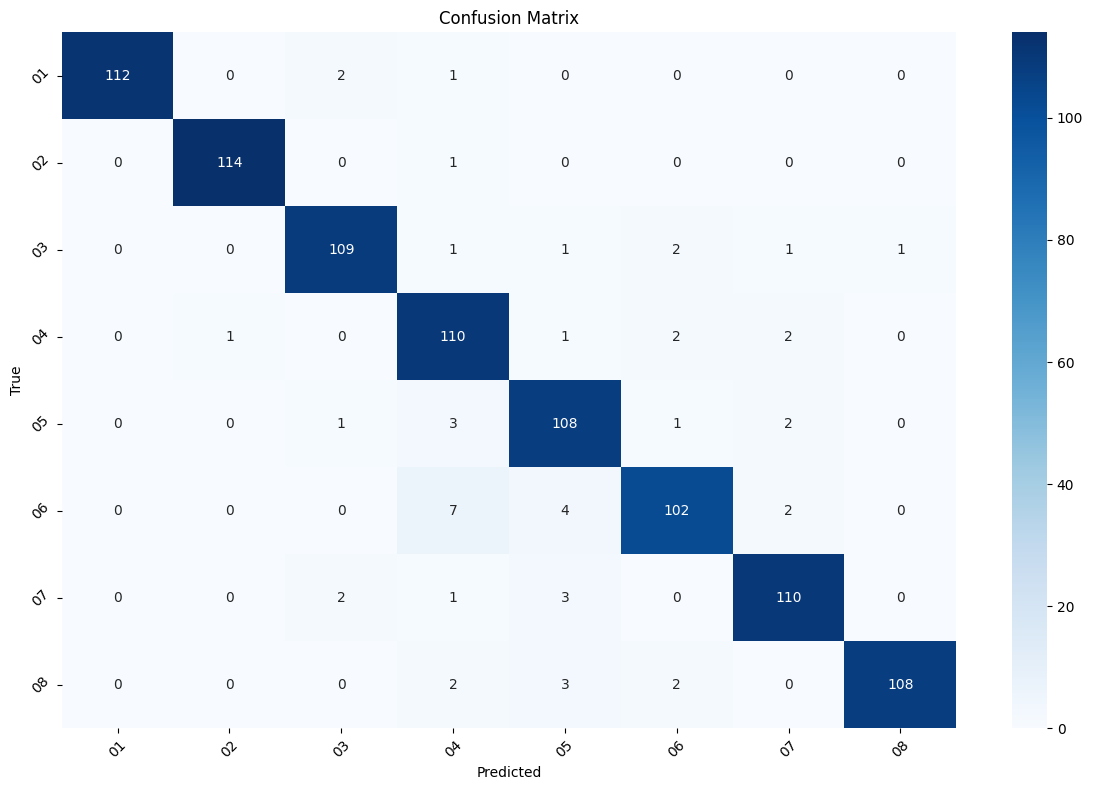

In [19]:
# Plot confusion matrix
plot_confusion_matrix_heatmap(y_test, y_pred, label_encoder)

In [20]:
# Save the model
print("\nSaving model...")
model_path = '/content/drive/MyDrive/ML/Emotion Recognition/emotion_classification.joblib'
dump(pipeline, model_path)
print("Model saved successfully!")


Saving model...
Model saved successfully!
